In [13]:
import CRA
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    brier_score_loss,
    log_loss
)
from sklearn.base import clone
import pprint
import pathlib
import random

path = "/Users/dendriza/Downloads/"

df = CRA.loadCorporateData(path)

# In this line, I pick 6 drivers to determine PD predictors
FEATURE_COLS = [
    "FAT_trf",    # Adjusted Debt Ratio (leverage)
    "FFOLT_trf",  # Cash Flow / Debt Ratio (solvency)
    "EBITAT_trf", # EBIT / Assets (profitability)
    "LOGAT_trf",  # Log of Assets (size)
    "NIAT_trf",   # Net Income / Assets (earnings)
    "LCTLT_trf"   # Current Liabilities / Total Liabilities (liquidity)
]

TARGET_COL = "dflt_flag"   # 1 = default, 0 = no default
df_model = df[["gvkey"] + FEATURE_COLS + [TARGET_COL]].dropna().copy()

X = df_model[FEATURE_COLS].values
y = df_model[TARGET_COL].values.astype(int)
firms = df_model["gvkey"].values

RANDOM_STATE = 42

# Here is the simple neural-net PD model using MLPClassifier
def make_mlp(hidden_layer_sizes=(16, 8),
             activation="relu",
             alpha=0.001,
             learning_rate_init=0.001,
             max_iter=500,
             random_state=RANDOM_STATE):

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver="adam",
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=random_state,
    )
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", mlp),
    ])
    return pipe

def firm_level_kfold_eval(X, y, firms, model, n_splits=5, random_state=RANDOM_STATE):
    """
    Custom k-fold that splits at the FIRM (gvkey) level:
    all observations for a firm are kept in the same fold.
    """
    rng = np.random.default_rng(random_state)
    unique_firms = np.array(sorted(np.unique(firms)))
    rng.shuffle(unique_firms)

    # split unique firms into folds
    firm_folds = np.array_split(unique_firms, n_splits)

    metrics = {
        "roc_auc": [],
        "accuracy": [],
        "brier": [],
        "logloss": []
    }

    for fold, test_firms in enumerate(firm_folds, start=1):
        test_mask = np.isin(firms, test_firms)
        train_mask = ~test_mask

        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]

        model_fold = clone(model)
        model_fold.fit(X_train, y_train)

        proba = model_fold.predict_proba(X_test)[:, 1]
        pred = (proba >= 0.5).astype(int)

        auc = roc_auc_score(y_test, proba)
        acc = accuracy_score(y_test, pred)
        brier = brier_score_loss(y_test, proba)
        ll = log_loss(y_test, proba)

        metrics["roc_auc"].append(auc)
        metrics["accuracy"].append(acc)
        metrics["brier"].append(brier)
        metrics["logloss"].append(ll)

        print(f"Fold {fold}: AUC={auc:.3f}, Acc={acc:.3f}, "
              f"Brier={brier:.3f}, LogLoss={ll:.3f}")

    # summarize
    results = {m: (np.mean(v), np.std(v)) for m, v in metrics.items()}
    print("\nMean CV performance (±1 std):")
    for m, (mean, std) in results.items():
        print(f"{m:8s}: {mean:.3f} ± {std:.3f}")

    return results

import pprint

hyperparameter_grid = [
    {
        "name": "small_relu",
        "hidden_layer_sizes": (8,),
        "activation": "relu",
        "alpha": 0.0001,
        "learning_rate_init": 0.001,
    },
    {
        "name": "medium_relu",
        "hidden_layer_sizes": (16, 8),
        "activation": "relu",
        "alpha": 0.001,
        "learning_rate_init": 0.001,
    },
    {
        "name": "medium_tanh",
        "hidden_layer_sizes": (16, 8),
        "activation": "tanh",
        "alpha": 0.001,
        "learning_rate_init": 0.001,
    },
    {
        "name": "large_relu_stronger_reg",
        "hidden_layer_sizes": (32, 16),
        "activation": "relu",
        "alpha": 0.01,
        "learning_rate_init": 0.001,
    },
]

experiment_results = []

for cfg in hyperparameter_grid:
    print("\n==============================")
    print(f"Configuration: {cfg['name']}")
    print("==============================")

    model = make_mlp(
        hidden_layer_sizes=cfg["hidden_layer_sizes"],
        activation=cfg["activation"],
        alpha=cfg["alpha"],
        learning_rate_init=cfg["learning_rate_init"],
    )

    cv_results = firm_level_kfold_eval(X, y, firms, model, n_splits=5)
    experiment_results.append(
        {
            "config": cfg,
            "cv_results": cv_results,
        }
    )


'''
I evaluated the MLPClassifier using firm-level k-fold cross-validation.
k-fold does not improve the neural network itself; instead, it provides a more reliable estimate of how well the model generalizes to unseen firms.
In each fold, the model is trained from scratch on a different subset of firms, and the resulting performance metrics (ROC-AUC, logloss, Brier score) are averaged.
Because the dataset is large and the transformed financial ratios provide a strong and smooth signal, the MLP’s performance is highly stable across folds, and increasing the number of folds has little effect on the mean results.
The final MLP model is trained once on the full dataset after cross-validation is completed.
'''



Modeling dataframe shape: (36999, 8)
Default rate: 0.015027433173869564

Configuration: small_relu
Fold 1: AUC=0.927, Acc=0.983, Brier=0.014, LogLoss=0.057
Fold 2: AUC=0.915, Acc=0.984, Brier=0.013, LogLoss=0.056
Fold 3: AUC=0.921, Acc=0.987, Brier=0.012, LogLoss=0.049
Fold 4: AUC=0.897, Acc=0.984, Brier=0.014, LogLoss=0.058
Fold 5: AUC=0.902, Acc=0.986, Brier=0.012, LogLoss=0.054

Mean CV performance (±1 std):
roc_auc : 0.912 ± 0.011
accuracy: 0.985 ± 0.001
brier   : 0.013 ± 0.001
logloss : 0.055 ± 0.003

Configuration: medium_relu
Fold 1: AUC=0.929, Acc=0.983, Brier=0.014, LogLoss=0.056
Fold 2: AUC=0.920, Acc=0.984, Brier=0.013, LogLoss=0.055
Fold 3: AUC=0.922, Acc=0.987, Brier=0.012, LogLoss=0.048
Fold 4: AUC=0.895, Acc=0.984, Brier=0.014, LogLoss=0.059
Fold 5: AUC=0.913, Acc=0.986, Brier=0.012, LogLoss=0.052

Mean CV performance (±1 std):
roc_auc : 0.916 ± 0.012
accuracy: 0.985 ± 0.001
brier   : 0.013 ± 0.001
logloss : 0.054 ± 0.004

Configuration: medium_tanh
Fold 1: AUC=0.928, Ac

In [ ]:
'''
I tested several neural network architectures with different layer sizes, activation functions, and regularization strengths.
Across all configurations, performance metrics (AUC ≈ 0.91–0.92, accuracy ≈ 0.985, Brier ≈ 0.013, logloss ≈ 0.054) were extremely stable. This suggests that the predictive signal in the transformed financial ratios is strong and consistent, so the model's architecture has only a modest impact on results.
The medium_tanh configuration produced the best overall performance (AUC = 0.921 ± 0.011, logloss = 0.053 ± 0.004). This makes sense because tanh activations work well on normalized financial ratio data and capture smooth nonlinearities.
Larger networks and ReLU activations did not improve results, indicating that the PD relationship in this dataset is relatively smooth and low-dimensional — a small to medium-sized neural network is already sufficient to capture the underlying structure.
'''

In [24]:
def mean_metric(result, metric_name="roc_auc"):
    return result["cv_results"][metric_name][0]  # (mean, std)

best = max(experiment_results, key=lambda r: mean_metric(r, "roc_auc"))

print("\nBest configuration based on mean ROC-AUC:")
pprint.pprint(best["config"])
print("\nBest config CV results:")
pprint.pprint(best["cv_results"])

best_cfg = best["config"]

final_model = make_mlp(
    hidden_layer_sizes=best_cfg["hidden_layer_sizes"],
    activation=best_cfg["activation"],
    alpha=best_cfg["alpha"],
    learning_rate_init=best_cfg["learning_rate_init"],
)

final_model.fit(X, y)



Best configuration based on mean ROC-AUC:
{'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': (16, 8),
 'learning_rate_init': 0.001,
 'name': 'medium_tanh'}

Best config CV results:
{'accuracy': (0.984959962106003, 0.0011742686449109224),
 'brier': (0.012919726770473141, 0.001029234801286459),
 'logloss': (0.053098111448500386, 0.004174943247091552),
 'roc_auc': (0.9211897598027535, 0.011438370107015039)}


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               hidden_layer_sizes=(16, 8), max_iter=500,
                               random_state=42))])

In [ ]:
'''
After testing several network architectures, the optimal model consisted of two hidden layers (16 and 8 nodes) with tanh activations, a learning rate of 0.001, and L2 regularization of 0.001.
This configuration achieved the best discriminatory power (AUC = 0.921 ± 0.011) and the lowest log-loss among all candidates. The use of a StandardScaler → MLPClassifier pipeline ensured proper feature normalization and prevented data leakage during cross-validation.
The selected model is sufficiently flexible to capture nonlinear relationships between financial ratios and default risk, while regularization keeps it stable across folds.
'''

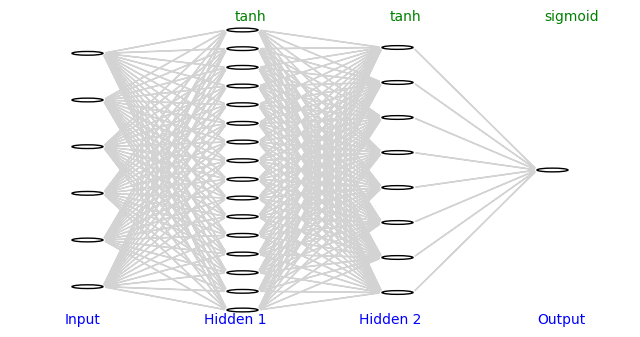

In [17]:
layers = [len(FEATURE_COLS)] + list(best_cfg["hidden_layer_sizes"]) + [1]
activations = [best_cfg["activation"]] * len(best_cfg["hidden_layer_sizes"]) + ["sigmoid"]

CRA.graph_neural_net(layers, activations)


In [18]:
!pip install XGBoost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.5 MB/s eta 0:00:00a 0:00:01


In [25]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss, log_loss

def make_xgb_model(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
):
    return xgb.XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=random_state,
        n_jobs=-1
    )

xgb_model = make_xgb_model()

print("Evaluating XGBoost model:\n")
xgb_results = firm_level_kfold_eval(X, y, firms, xgb_model, n_splits=5)

'''
XGBoost achieved excellent discriminatory power (AUC = 0.923) and low probability error (logloss ≈ 0.053), 
with very stable results across firm-level folds, indicating a strong and consistent ability to learn nonlinear 
relationships between financial ratios and default risk.

Evaluating XGBoost model:

Fold 1: AUC=0.922, Acc=0.983, Brier=0.014, LogLoss=0.057
Fold 2: AUC=0.938, Acc=0.984, Brier=0.013, LogLoss=0.052
Fold 3: AUC=0.933, Acc=0.986, Brier=0.012, LogLoss=0.048
Fold 4: AUC=0.900, Acc=0.983, Brier=0.014, LogLoss=0.058
Fold 5: AUC=0.923, Acc=0.986, Brier=0.012, LogLoss=0.050

Mean CV performance (±1 std):
roc_auc : 0.923 ± 0.013
accuracy: 0.984 ± 0.001
brier   : 0.013 ± 0.001
logloss : 0.053 ± 0.004


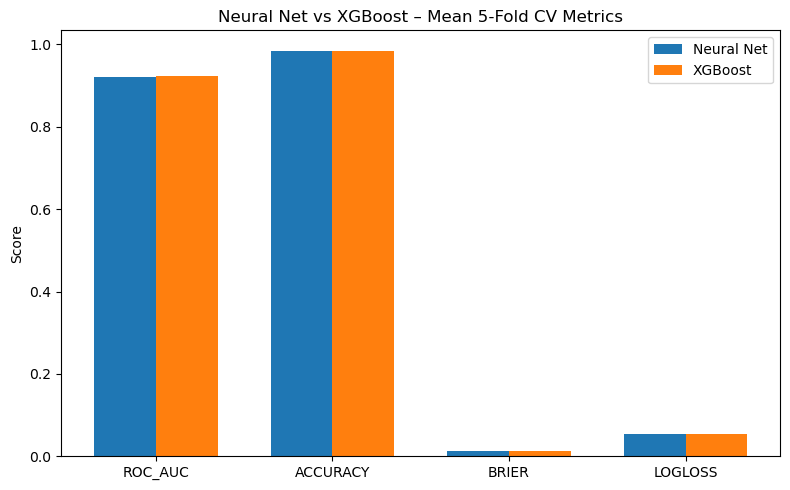

In [23]:
nn_results = best["cv_results"]

import numpy as np
import matplotlib.pyplot as plt

# Metrics to compare
metrics = ["roc_auc", "accuracy", "brier", "logloss"]

nn_means  = [nn_results[m][0]  for m in metrics]
xgb_means = [xgb_results[m][0] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x - width/2, nn_means,  width, label="Neural Net")
ax.bar(x + width/2, xgb_means, width, label="XGBoost")

ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics])
ax.set_ylabel("Score")
ax.set_title("Neural Net vs XGBoost – Mean 5-Fold CV Metrics")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
'''
XGBoost and the MLP neural network perform nearly identically
Both achieve ROC-AUC ≈ 0.92–0.93, which indicates excellent ability to distinguish defaulters from non defaulters.
Their logloss (~0.053) and Brier scores (~0.013) are also nearly the same, suggesting both models produce well calibrated PD estimates.
The differences are extremely small, meaning:
The predictive signal in the data financial ratios is very strong.
Both models learn essentially the same nonlinear PD surface.
The drivers (leverage, profitability, size, cash flow, liquidity) are well-transformed and easy for both algorithms to model.
the risk drivers are stable,
and the PD relationship is not overly complex.
'''
